In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import myRC
import sys
import scipy.interpolate as scInterp
from scipy.stats.distributions import chi2 as scipy_chi2
from lmfit import Model, Parameters, models
from datetime import datetime


def interp_models(parameter, chi2_array):
    # make array with the minima of the parameter (unique values)
    param_u = np.unique(parameter)
    param_chi = []
    # if the parameter was not explored:

    if len(param_u) < 3:
        print("Too few values to interpolate.")
        param_chi, param_arr, param_interp = np.nan, np.nan, np.nan
    # interpolate between the minimum chi2 of the different models
    else:
        # get chi2 for the minima
        for i in range(len(param_u)):
            param_chi.append(np.min(chi2_array[parameter == param_u[i]]))

        # interpolate chi2 minima
        interp = scInterp.interp1d(param_u, param_chi, kind='cubic',
                                   fill_value="extrapolate")
        # make finer grid of parameter to interpolate minima on
        min, max = np.min(param_u), np.max(param_u)  # + 0.01*np.min(param_u)
        step = (param_u[1]-param_u[0]) / 10
        param_arr = np.arange(min, max, step)

        # map minima to new array
        param_interp = interp(param_arr)
    return param_u, param_chi, param_arr, param_interp


def get_errs(param_arr, param_interp, conf_level, val_min):
    # intersection between the curves
    idxs = np.argwhere(np.diff(np.sign(param_interp - conf_level))).flatten()
    if len(idxs) == 0:
        print("No errors could be determined.")
        err_l = np.nan
        err_u = np.nan

    elif len(idxs) == 1:
        print("Only one error determined")
        # intersection exactly the same as value => no error
        if param_arr[idxs] == val_min:
            err_u = np.nan
            err_l = np.nan
        if param_arr[idxs] < val_min:
            err_l = val_min - param_arr[idxs][0]
            err_u = np.nan
        elif param_arr[idxs] > val_min:
            err_u = param_arr[idxs][0] - val_min
            err_l = np.nan

    elif len(idxs) == 2:
        err_l = abs(val_min - param_arr[idxs[0]])
        err_u = abs(param_arr[idxs[1]] - val_min)

    elif len(idxs) > 2:
        # more that one interception with conf level => lowest and highest
        err_l = abs(val_min - param_arr[idxs[0]])
        err_u = abs(param_arr[idxs[-1]] - val_min)
    else:
        print("Error determination went somehow wrong")
        err_l = np.nan
        err_u = np.nan

    return(err_l, err_u)

def parab(x, a, h, k):
    "Parabola, center = (h, k)"
    return a*(x-h)**2 + k

def parab_interc(y, a, h, k):
    "return x-value for certain y"
    return h-np.sqrt((y-k)/a), h+np.sqrt((y-k)/a)

def fit_parab(x, y, a , h, k):
    pars = Parameters()
    pbol = Model(parab)
    pars.update(pbol.make_params())
    pars['a'].set(a, min=0)
    pars['h'].set(h, min=0)
    pars['k'].set(k, min=0)
    mod = pbol
    results = mod.fit(y, pars, x=x)
    return results



(0.31374101061920684, 0.40908440264990703)


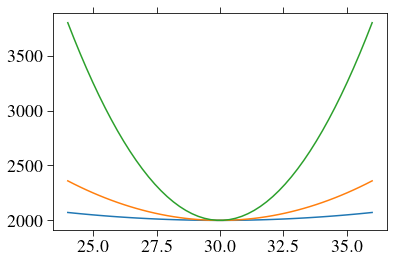

In [140]:
aa = 97318.91775738035
hh = 0.36141270663455694
kk = 1979.3796679446377
print(parab_interc(conf_level, aa, hh, kk))

x_vals = np.linspace(24, 36, 50)
plt.plot(x_vals, parab(x_vals, 2, 30, 2000))
plt.plot(x_vals, parab(x_vals, 10, 30, 2000))
plt.plot(x_vals, parab(x_vals, 50, 30, 2000))

In [43]:
tab_file1 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-01.csv'
tab_file2 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_negative.csv'
tab_file3 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_extra-lrat.csv'
tab_file4 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-02_extra-He2H.csv'
tab_file5 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_extra-TeffB.csv'
tab_file6 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_rotB500_missing.csv'
tab_file7 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_he2h0.14.csv'
tab_file8 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-03_extra-TeffA.csv'
tab_file9 = '/home/jaime/science/KUL/minchi2_result_he2honA_2022-08-04_extra-rotA.csv'

dof = 2100-7
secondary=True
params='vary'

tab_in1 = pd.read_csv(tab_file1)
tab_in2 = pd.read_csv(tab_file2)
tab_in3 = pd.read_csv(tab_file3)
tab_in4 = pd.read_csv(tab_file4)
tab_in5 = pd.read_csv(tab_file5)
tab_in6 = pd.read_csv(tab_file6)
tab_in7 = pd.read_csv(tab_file7)
tab_in8 = pd.read_csv(tab_file8)
tab_in9 = pd.read_csv(tab_file9)

tab_in8['loggA'].replace([22.5, 27.5], [22, 28], inplace=True)
tab_in8 = tab_in8[(~tab_in8['loggA'].isin([25, 30])) & (tab_in8['TeffA']!=18)]

# tab_in4 = tab_in4[tab_in4['rotB']!=500]
# tab_in = pd.concat([tab_in1, tab_in2])
tab_inA = pd.concat([tab_in1, tab_in2], ignore_index=True)
tab_inB = pd.concat([tab_in3, tab_in4], ignore_index=True)
tab_inC = pd.concat([tab_in5, tab_in6], ignore_index=True)
tab_inD = pd.concat([tab_in7, tab_in8], ignore_index=True)
tab_inAB = pd.concat([tab_inA, tab_inB], ignore_index=True)
tab_inCD = pd.concat([tab_inC, tab_inD], ignore_index=True)
tab_in = pd.concat([tab_inAB, tab_inCD], ignore_index=True)
tab_in = pd.concat([tab_in, tab_in9], ignore_index=True)
# display(tab_in)

# remove chi2 values < 0
# tab = tab_in[tab_in['chi2']>=0]
tab = tab_in[(tab_in['chi2']>=0) & (tab_in['loggA']!=19) & (tab_in['He2H']!=0.8)]
# tab = tab_in[(tab_in['chi2']>=0) & (tab_in['rotB']<500) & (tab_in['loggA']!=19)]
tab = tab[~tab['He2H'].isin([0.07, 0.075, 0.085, 0.09, 0.095])]
tab = tab[~tab['TeffB'].isin([16, 20])]

# display(tab[(tab['He2H']==0.12) & (tab['rotB']==100)])

# bins=np.linspace(100, 600, 6)
# print(bins)
# sham = plt.hist(tab['rotB'], bins=bins)
# print(sham[0])

# bins=np.linspace(25, 55, 7)
# print(bins)
# sham = plt.hist(tab['lrat']*100, bins=bins)
# print(sham[0])

# bins=np.linspace(5, 14.5, 20)
# print(bins)
# sham = plt.hist(tab['He2H']*100, bins=bins)
# print(sham[0])

# plt.xlim(0.2, 0.65)
# help(plt.hist)
# display(tab[tab['lrat']==0.25])

# read in unscaled chi2
unscaled_chi2 = tab['chi2']

# tab = tab[tab['rotB']==500]

# display(tab[(tab['lrat']==0.25) & (tab['He2H']==0.1) & (tab['TeffB']==27.5)])
# display(tab[(tab['lrat']==0.25) & (tab['He2H']==0.08)])

# from iteration_utilities import duplicates, unique_everseen
# print(list(unique_everseen(duplicates(tab['loggB'][tab['He2H']==0.12]))))
# print(list(unique_everseen(duplicates(tab['loggB'][tab['He2H']==0.1]))))

# print('difference between lrat 0.25 and 0.3 = ', len(tab[tab['lrat']==0.3]) - len(tab[tab['lrat']==0.25]))

# bins=np.linspace(25, 55, 7)
# print(bins)
# plt.hist(tab['lrat']*100, bins=bins)

# print(len(tab[(tab['lrat']==0.35) & (tab['He2H']==0.12)]))
# print(len(tab[(tab['lrat']==0.35) & (tab['He2H']==0.1)]))

# sys.exit()

# renormalize the chi2 such that the best fit corresponds to a chi2 = dof
# which is similar to setting the reduced chi2 =1
chi2 = unscaled_chi2 / unscaled_chi2.min() * dof

# get confidence level
conf_level = scipy_chi2.ppf(0.95, dof)

teffA, loggA, rotA = tab['TeffA'], tab['loggA']/10, tab['rotA']
teffB, loggB, rotB = tab['TeffB'], tab['loggB']/10, tab['rotB']
lrat, he2h = tab['lrat'], tab['He2H']

# pars = [lrat, he2h, teffA, loggA, rotA, teffB, loggB, rotB]
pars = [lrat, he2h, teffA, loggA, teffB, loggB, rotA, rotB]

# get minimum of chi2
idx_min = chi2.idxmin()

# interpolate between the minima
print('Your best fit is:')
pars_min = []
fit_pars = []
for par in pars:
    par_i, par_chi, par_arr, par_interp = interp_models(par, chi2)
    pars_min.append([par_i, par_chi])
    # get best-fit value with respective errors
    par_val = par[idx_min]
    par_l, par_u = get_errs(par_arr, par_interp, conf_level, par_val)
    if par.name in ['TeffA', 'TeffB']:
        par_l, par_u = round(par_l, 2), round(par_u, 2)

    # Print the best fit paramters
#     print(' '+par.name+' = {:.2f}'.format(par_val) + ' +{:.2f}'.format(par_u) +
#           ' -{:.2f}'.format(par_l) )
#     print(' ',par.name,' = {:.2f}'.format(par_val), ' +{:.2f}'.format(par_u),\
#           ' -{:.2f}'.format(par_l) )
#     print(' ', par.name, ' = ', par_val, ' + ', par_u, ' - ', par_l )
    
    
    # fit parabola
#     a = (par_arr[-1]-par_arr[0])/10
    a = 10
    h = par_val
    k = min(par_chi)
    fit_res = fit_parab(par_i, par_chi, a , h, k)
#     print(fit_res.fit_report())
#     print(fit_res.best_values, '\n')
    fit_pars.append(fit_res.best_values)
    intercept = parab_interc(conf_level, fit_res.best_values['a'], fit_res.best_values['h'], fit_res.best_values['k'])
#     print(intercept)
    # Print the best fit paramters
#     print(par_interp)
#     print(conf_level)
    value = fit_res.best_values['h']
    error = value - intercept[0]
    print(' '+par.name+' = '+f'{value:.2f}'+' +/- '+f'{error:.2f}')

Your best fit is:
 lrat = 0.36 +/- 0.05
 He2H = 0.11 +/- 0.03
 TeffA = 13.86 +/- 1.25
 loggA = 2.43 +/- 0.21
Only one error determined
 TeffB = 24.67 +/- 4.19
 loggB = 3.32 +/- 0.30
 rotA = 33.00 +/- 17.49
 rotB = 337.91 +/- 120.93


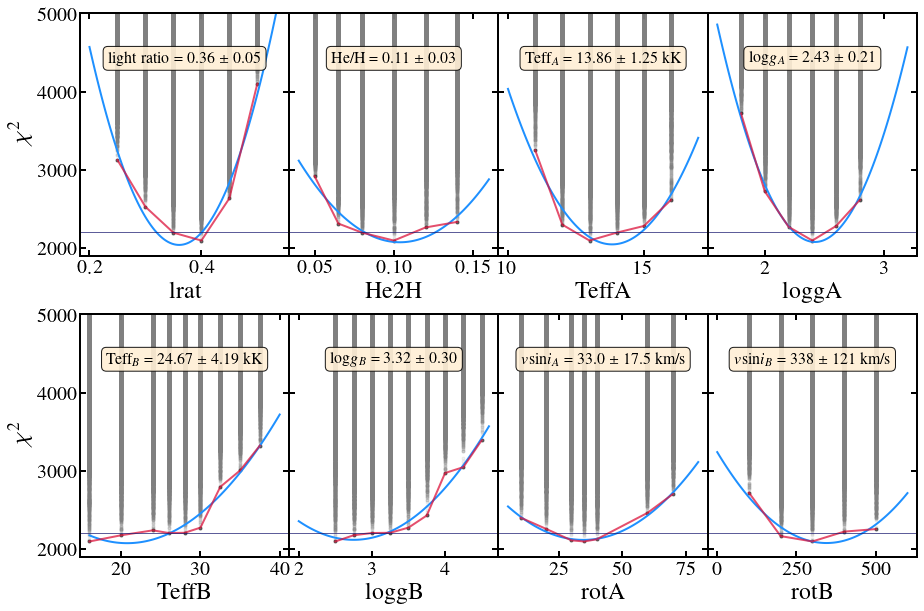

In [26]:
current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d-%H:%M")

# labels= [ r'light ratio = 0.36 $\pm$ 0.05', r'He/H = 0.11 $\pm$ 0.03', r'Teff$_A$ = 13.54 $\pm$ 1.13 kK', \
#           r'log$g_A$ = 2.37 $\pm$ 0.19', r'Teff$_B$ = 24.75 $\pm$ 4.14 kK', r'log$g_B$ = 3.30 $\pm$ 0.34', \
#           r'$v$sin$i_B$ = 336 $\pm$ 118 km/s']

labels= [ r'light ratio = 0.36 $\pm$ 0.05', r'He/H = 0.11 $\pm$ 0.03', r'Teff$_A$ = 13.86 $\pm$ 1.25 kK', \
        r'log$g_A$ = 2.43 $\pm$ 0.21', r'Teff$_B$ = 24.67 $\pm$ 4.19 kK', \
        r'log$g_B$ = 3.32 $\pm$ 0.30', r'$v$sin$i_A$ = 33.0 $\pm$ 17.5 km/s', r'$v$sin$i_B$ = 338 $\pm$ 121 km/s']

props = dict(boxstyle='round', facecolor='papayawhip', alpha=0.9)
vmin, vmax = min(chi2), 2.*conf_level
pars_limits =[[0.2, 0.54], [0.04, 0.16], [10, 17], [1.6, 3.2], [16, 40], [2, 4.6], [5, 80], [0, 600]]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(5*3, 5*2), sharey=True)
fig.subplots_adjust(wspace=0., hspace=0.24)
ax = axes.flatten()
for i, par, minval in zip(range(len(pars)), pars, pars_min):
    ax[i].plot(par, chi2, ls='None', marker='.', c='grey', alpha=0.1)
    ax[i].plot(pars_min[i][0], pars_min[i][1], 'k.', alpha=0.5)
#     x_parab = np.linspace(pars_min[i][0][0], pars_min[i][0][-1], 100)
    x_parab = np.linspace(pars_limits[i][0], pars_limits[i][1], 100)
    y_parab = parab(x_parab, fit_pars[i]['a'], fit_pars[i]['h'], fit_pars[i]['k'])
    ax[i].plot(x_parab, y_parab, lw=2, c='dodgerblue')
#     ax[7].plot(rotA, chi2, 'k.', alpha=0.5)
#     ax[7].set_xlabel('rotA')
    ax[i].plot(minval[0], minval[1], 'crimson', lw=2, alpha=.75)
    ax[i].axhline(conf_level, color='midnightblue', lw=1, alpha=0.7)
    # ax[i].set_title(par.name)
    ax[i].set_xlabel(par.name)
    if i in [0, 4]:
        ax[i].set_ylabel(r'$\chi^2$')
    ax[i].text(0.5, 0.8, labels[i], fontsize=16, horizontalalignment='center', transform = ax[i].transAxes, bbox=props)
ax[0].set_ylim(vmin-200, 5000)

# plt.savefig('errors_'+current_date+'.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

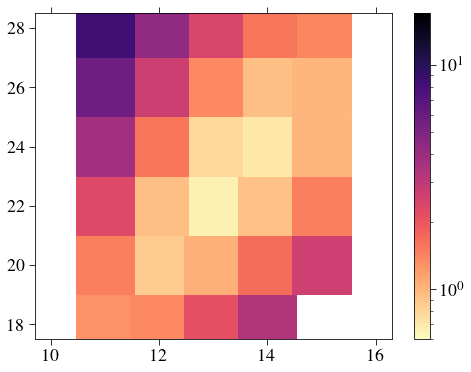

In [355]:
import matplotlib.cm as cm
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8,6))
cmap=cm.get_cmap('magma_r')
norm = mpl.colors.LogNorm(vmin=0.6, vmax=17)
cond = (tab['lrat'] == 0.35) & (tab['He2H'] == 0.1) & (tab['TeffB'] == 30) & (tab['loggB'] == 35)  & \
        (tab['rotA'] == 40) & (tab['rotB'] == 200)
ax_ = ax.scatter(tab['TeffA'][cond], tab['loggA'][cond], c=tab['chi2'][cond], s=3390, marker='s', cmap=cmap, norm=norm)
cbar = plt.colorbar(ax_, ax=ax)
ax.set_xlim(9.7, 16.3)
plt.show()
plt.close()
# display(tab[cond].sort_values(by=['TeffA', 'loggA'])[:50])

In [1]:
# condi = (tab['lrat'] == 0.4) & (tab['He2H'] == 0.08) & (tab['TeffA'] == 13) & (tab['loggA'] == 24) & \
#        (tab['rotA'] == 35) & (tab['TeffB'] == 30) & (tab['loggB'] == 35)  & (tab['rotB'] == 200 )
condi = (tab['lrat'] == 0.35) & (tab['rotB'] == 100)# & (tab['loggB'] == 40)
# condi = (tab['TeffB'] == 30) & (tab['loggB'] == 35)  & (tab['rotB'] == 200 )
# display(tab[condi].sort_values(by=['lrat', 'He2H', 'TeffA', 'loggA', 'rotA', 'TeffB', 'loggB', 'rotB', 'chi2']))
# display(tab.sort_values(by=['chi2'])[:15])
display(tab.sort_values(by=['chi2'])[:15])

NameError: name 'tab' is not defined

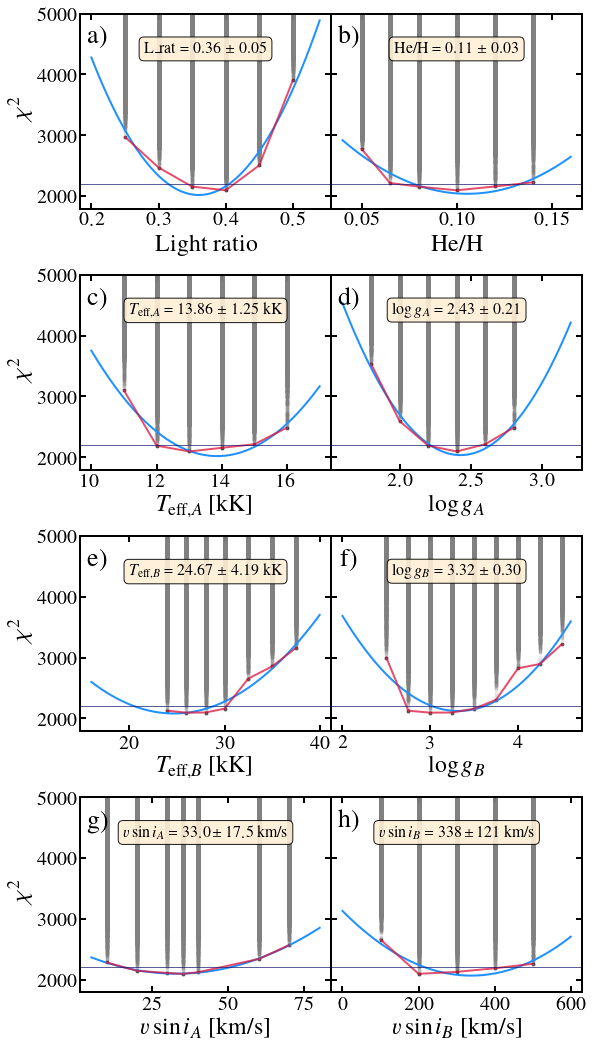

In [7]:
labels= [ r'L_rat = 0.36 $\pm$ 0.05', r'He/H = 0.11 $\pm$ 0.03', r'$T_{\text{eff}, A}$ = 13.86 $\pm$ 1.25 kK', \
        r'$\log g_A$ = 2.43 $\pm$ 0.21', r'$T_{\text{eff}, B}$ = 24.67 $\pm$ 4.19 kK', r'$\log g_B$ = 3.32 $\pm$ 0.30', \
        r'$\varv \sin i_A = 33.0 \pm 17.5$ km/s', r'$\varv\sin i_B = 338 \pm 121$ km/s']

x_labels = ['Light ratio', 'He/H', r'$T_{\text{eff}, A}$ [kK]', r'$\log g_A$', r'$T_{\text{eff}, B}$ [kK]', \
        r'$\log g_B$', r'$\varv \sin i_A$ [km/s]', r'$\varv \sin i_B$ [km/s]']
props = dict(boxstyle='round', facecolor='papayawhip', alpha=0.9)
vmin, vmax = min(chi2), 2.*conf_level
pars_limits =[[0.2, 0.54], [0.04, 0.16], [10, 17], [1.6, 3.2], [16, 40], [2, 4.6], [5, 80], [0, 600]]
panels_id = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9*1, 9*2), sharey=True)
fig.subplots_adjust(wspace=0., hspace=0.34)
ax = axes.flatten()
for i, par, minval in zip(range(len(pars)), pars, pars_min):
    ax[i].plot(par, chi2, ls='None', marker='.', c='grey', alpha=0.1)
    ax[i].plot(pars_min[i][0], pars_min[i][1], 'k.', alpha=0.5)
#     x_parab = np.linspace(pars_min[i][0][0], pars_min[i][0][-1], 100)
    x_parab = np.linspace(pars_limits[i][0], pars_limits[i][1], 100)
    y_parab = parab(x_parab, fit_pars[i]['a'], fit_pars[i]['h'], fit_pars[i]['k'])
    ax[i].plot(x_parab, y_parab, lw=2, c='dodgerblue')
#     ax[7].plot(rotA, chi2, 'k.', alpha=0.5)
#     ax[7].set_xlabel('rotA')
    ax[i].plot(minval[0], minval[1], 'crimson', lw=2, alpha=.75)
    ax[i].axhline(conf_level, color='midnightblue', lw=1, alpha=0.7)
    # ax[i].set_title(par.name)
    ax[i].set_xlabel(x_labels[i])
    if i in [0, 2, 4, 6]:
        ax[i].set_ylabel(r'$\chi^2$')
    ax[i].text(0.5, 0.8, labels[i], fontsize=16, horizontalalignment='center', transform = ax[i].transAxes, bbox=props)
    ax[i].text(0.07, 0.84, panels_id[i], fontsize=26, horizontalalignment='center', transform = ax[i].transAxes)
ax[0].set_ylim(vmin-300, 5000)

# plt.savefig('errors_paper.pdf', bbox_inches='tight')
plt.savefig('errors_paper.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [17]:
93/15

6.2